In [3]:
# Azure Libaries
from azureml.core import Datastore
from azureml.core.dataset import Dataset
from azureml.core.workspace import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication

In [4]:
# Common Python Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import math
import datetime as dt
import os
import logging
from dateutil.relativedelta import relativedelta
from operator import attrgetter
from datetime import datetime

In [5]:
# SKlearn Libraries # CHANGE HERE TO MATCH YOUR ALGORITHM
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pylab as plt
from matplotlib import pyplot
from collections import Counter

### Connect to Your Workspace

In [19]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.6.0 to work with ml-teaching-workspace


### Prepare Data for Automated Machine Learning

In [25]:
# Retrieve your Datasets by name
ds_name  = "auto-mpg-classification-input" # CHANGE HERE

auto_mpg_ds = ws.datasets.get(ds_name)


### Split the data into train and test

In [26]:
# Split the dataset into training and validation subsets

train_ds, test_ds = auto_mpg_ds.random_split(percentage=0.8, seed=123)
print("Data ready!")

Data ready!


### Prepare a Compute Target

#### One of the benefits of cloud compute is that it scales on-demand, enabling you to provision enough compute resources to process multiple runs of an experiment in parallel. You'll use an Azure Machine Learning compute cluster named aml-cluster (if it doesn't exist, it will be created).

In [27]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "aml-cluster"

try:
    # Get the cluster if it exists
    training_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # If not, create it
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS2_V2', max_nodes=2)
    training_cluster = ComputeTarget.create(ws, cluster_name, compute_config)

training_cluster.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


### Configure Automated Machine Learning

#### Now you're ready to configure the automated machine learning experiment. To do this, you'll need a run configuration that includes the required packages for the experiment environment, and a set of configuration settings that specifies how many combinations to try, which metric to use when evaluating models, and so on.

In [30]:
from azureml.train.automl import AutoMLConfig

automl_config = AutoMLConfig(name='Automated ML Experiment',
                             task='regression',
                             compute_target=training_cluster,
                             training_data = train_ds,
                             validation_data = test_ds,
                             label_column_name='Column1',
                             iterations=6,
                             primary_metric = 'normalized_root_mean_squared_error',
                             max_concurrent_iterations=2,
                             featurization='auto'
                             )

print("Ready for Auto ML run.")

Ready for Auto ML run.


### Run an Automated Machine Learning Experiment

In [31]:
from azureml.core.experiment import Experiment
from azureml.widgets import RunDetails

print('Submitting Auto ML experiment...')
automl_experiment = Experiment(ws, 'auto-mpg-automl')
automl_run = automl_experiment.submit(automl_config)
RunDetails(automl_run).show()
automl_run.wait_for_completion(show_output=True)

Submitting Auto ML experiment...
Running on remote or ADB.


_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…


Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

TYPE:         High cardinality feature detection
STATUS:       DONE
DESCRIPTION:  High cardinality features were detected in your inputs and handled.
              Learn more about high cardinality feature handling: https://aka.ms/AutomatedMLFeaturization
DETAILS:      High cardinality features refer to columns that contain a large percentage of unique values.
+---------------------------------+---------------------------------+
|Column name                      |Column

{'runId': 'AutoML_a546b2d3-26f1-441b-8a16-542fe553b821',
 'target': 'aml-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-06-03T16:04:13.78369Z',
 'endTimeUtc': '2020-06-03T16:11:04.921753Z',
 'properties': {'num_iterations': '6',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'aml-cluster',
  'RawAMLSettingsString': "{'name': 'Automated ML Experiment', 'path': None, 'subscription_id': 'dcfc206a-203b-4c00-a236-bdf576a37896', 'resource_group': 'ml-teaching', 'workspace_name': 'ml-teaching-workspace', 'region': 'centralus', 'compute_target': 'aml-cluster', 'spark_service': None, 'azure_service': 'Microsoft.AzureNotebookVM', '_local_managed_run_id': None, 'iterations': 6, 'primary_metric': 'normalized_root_mean_squared_error', 'task_type': 'regression', 'data_script': None, 'validation_size': 0.0, 'n_cross_vali

### Determine the Best Performing Model

In [32]:
best_run, fitted_model = automl_run.get_output()
print(best_run)
print(fitted_model)
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, metric)

[16:30:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Run(Experiment: auto-mpg-automl,
Id: AutoML_a546b2d3-26f1-441b-8a16-542fe553b821_4,
Type: azureml.scriptrun,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...         flatten_transform=None,
               weights=[0.8333333333333334, 0.16666666666666666]))]),
          stddev=None)
predicted_true aml://artifactId/ExperimentRun/dcid.AutoML_a546b2d3-26f1-441b-8a16-542fe553b821_4/predicted_true
residuals aml://artifactId/ExperimentRun/dcid.AutoML_a546b2d3-26f1-441b-8a16-542fe553b821_4/residuals
normalized_median_absolute_error 0.03878277959562044
r2_sc

#### Automated machine learning includes the option to try preprocessing the data

In [33]:
for step in fitted_model.named_steps:
    print(step)

datatransformer
prefittedsoftvotingregressor


### Evaluate the best performing model

In [34]:
# preview the first 3 rows of the dataset

test_ds = test_ds.to_pandas_dataframe()
y_test = test_ds['Column1'].fillna(0)
test_ds = test_ds.drop('Column1', 1)
test_ds = test_ds.fillna(0)


train_ds = train_ds.to_pandas_dataframe()
y_train = train_ds['Column1'].fillna(0)
train_ds = train_ds.drop('Column1', 1)
train_ds = train_ds.fillna(0)

In [35]:
y_pred_train = fitted_model.predict(train_ds)
y_residual_train = y_train - y_pred_train

y_pred_test = fitted_model.predict(test_ds)
y_residual_test = y_test - y_pred_test

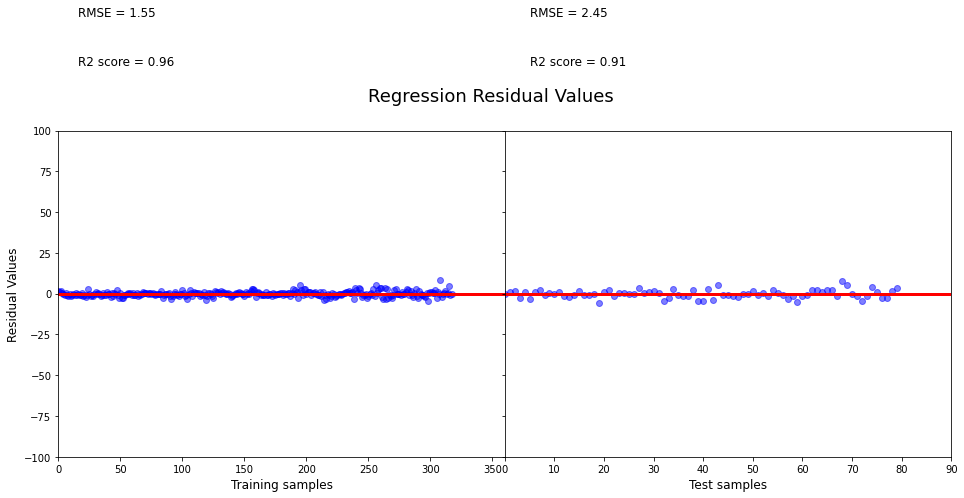

In [36]:
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score

# Set up a multi-plot chart.
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Regression Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(16)

# Plot residual values of training set.
a0.axis([0, 360, -100, 100])
a0.plot(y_residual_train, 'bo', alpha = 0.5)
a0.plot([-10,360],[0,0], 'r-', lw = 3)
a0.text(16,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))), fontsize = 12)
a0.text(16,140,'R2 score = {0:.2f}'.format(r2_score(y_train, y_pred_train)),fontsize = 12)
a0.set_xlabel('Training samples', fontsize = 12)
a0.set_ylabel('Residual Values', fontsize = 12)

# Plot residual values of test set.
a1.axis([0, 90, -100, 100])
a1.plot(y_residual_test, 'bo', alpha = 0.5)
a1.plot([-10,360],[0,0], 'r-', lw = 3)
a1.text(5,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))), fontsize = 12)
a1.text(5,140,'R2 score = {0:.2f}'.format(r2_score(y_test, y_pred_test)),fontsize = 12)
a1.set_xlabel('Test samples', fontsize = 12)
a1.set_yticklabels([])

plt.show()